In [1]:
import theano.sandbox.cuda
theano.sandbox.cuda.use("gpu0")

Using gpu device 1: GeForce GTX 780
WARNING (theano.sandbox.cuda): Ignoring call to use(0), GPU number 1 is already in use.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
%ls -rlth

total 7.5G
-rw-r--r-- 1 dueo dueo  2.3G Jul 28 20:17 HCS_48x48.npz
-rw-r--r-- 1 dueo dueo  965K Jul 29 11:16 DataHandling.ipynb
-rw-r--r-- 1 dueo dueo   229 Jul 29 11:55 README.md
-rw-r--r-- 1 dueo dueo  2.6M Jul 29 20:43 net_aug_epoch42_91prec.pickle
-rw-r--r-- 1 dueo dueo  2.6M Jul 29 21:13 net_aug_epoch69_92prec.pickle
-rw-r--r-- 1 dueo dueo  5.2G Jul 29 21:17 HCS_72x72.npz
-rw-r--r-- 1 dueo dueo  2.6M Jul 30 01:03 net_aug_epoch300_92prec.pickle
-rw-r--r-- 1 dueo dueo  2.6M Jul 30 11:22 net_aug_epoch400_all_rot_92prec.pickle
-rw-r--r-- 1 dueo dueo  3.2M Jul 30 12:23 HCS_72x72_small_32.npz
-rw-r--r-- 1 dueo dueo 1010K Jul 30 13:10 FirstNetwork_dummy.ipynb
-rw-r--r-- 1 dueo dueo  4.9M Jul 31 09:59 net_aug_epoch400_large_net.pickle
-rw-r--r-- 1 dueo dueo   14M Jul 31 23:47 net_aug_epoch242_72x72large_net.pickle
-rw-r--r-- 1 dueo dueo  3.9M Aug  1 13:34 net_aug_epoch800_48x48_all_rot_prec93.pickle
-rw-r--r-- 1 dueo dueo   14M Aug  3 13:42 net_aug_epoch800_72x72large_net.pickle
-rw-r--r-

In [3]:
import skimage
skimage.__version__ # We need at least version 0.11.3

'0.11.3'

In [4]:
import gzip
import numpy as np
from sklearn.cross_validation import KFold
from sklearn.cross_validation import StratifiedKFold
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import time
%matplotlib inline

In [5]:
start = time.time()
npzfile = np.load('HCS_72x72.npz')
print ("Loaded data in " + str(time.time() - start))

Loaded data in 0.000494956970215


In [6]:
npzfile.files

['arr_1', 'arr_0', 'arr_2']

In [7]:
start = time.time()
cell_rows = npzfile['arr_0']
X = npzfile['arr_1']
Y = npzfile['arr_2']
print ("Loaded data in " + str(time.time() - start))

Loaded data in 10.406375885


In [8]:
np.shape(cell_rows), np.shape(Y), np.shape(X), type(X)

((52950,), (52950,), (52950, 5, 72, 72), numpy.ndarray)

(-0.5, 3.5)

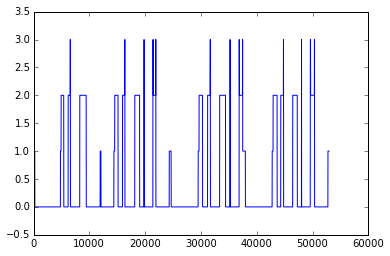

In [9]:
plt.plot(Y)
plt.ylim(-0.5,3.5)

### Normalization

In [10]:
Xmean = X.mean(axis = 0)
XStd = np.sqrt(X.var(axis=0))
X = (X-Xmean)/(XStd + 0.01)

In [12]:
np.min(X), np.max(X), np.mean(X) #(-2.5272908, 58.301613, -3.3162789e-07)

(-2.5272908, 58.301613, -3.3162789e-07)

In [14]:
Y = np.asarray(Y,dtype='int32')

### Some examples (after normalization)
rows are the different compounds

#### Version 2
80%, 20% randomly choosen

In [15]:
# Currently a Acc. of 0.8976
np.random.seed(seed=42)
perm1 = np.random.permutation(len(Y))
print('Sum of permutation {0}'.format(np.sum(perm1))) #1401824775
N_split = int(len(Y) * 0.8)
N_split
idx_train  = perm1[:N_split]
idx_test  = perm1[N_split:]
    

X_train = X[idx_train,:,:,:]
Y_train = Y[idx_train]
X_test = X[idx_test,:,:,:]
Y_test = Y[idx_test]

Sum of permutation 1401824775


#### Permuting the training set

In [16]:
perm = np.random.permutation(len(Y_train))
XX = X_train[perm,:,:,:]
YY = Y_train[perm]
YY = np.asarray(YY,dtype='int32')

## Architekture of the network
This Network is inspired by the oxford net VGGNet, see e.g. http://cs231n.github.io/convolutional-networks/#case

* Convolution with 3x3 layers (stride = 1 and pad = 1)
* Pooling 2x2 (stride = 2 no padding)

In [17]:
PIXELS = 72

from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet

conv = (3,3)
stride = (1,1)
pool = (2,2)

num1 = 32
num2 = 64
num3 = 128
num4 = 256
num5 = 256

net_bigger = NeuralNet(
    # Geometry of the network
    layers=[
        ('input', layers.InputLayer),
        
        ('conv1', layers.Conv2DLayer),
        ('conv11', layers.Conv2DLayer),
        ('pool1', layers.MaxPool2DLayer),
        
        ('conv2', layers.Conv2DLayer),
        ('conv22', layers.Conv2DLayer),
        ('pool2', layers.MaxPool2DLayer),
        
        ('conv3', layers.Conv2DLayer),
        ('conv33', layers.Conv2DLayer),
        ('pool3', layers.MaxPool2DLayer),
        
#         ('conv4', layers.Conv2DLayer),
#         ('conv44', layers.Conv2DLayer),
#         ('pool4', layers.MaxPool2DLayer),
        
#         ('conv5', layers.Conv2DLayer),
#         ('conv55', layers.Conv2DLayer),
#         ('pool5', layers.MaxPool2DLayer),
                
              
        ('hidden1', layers.DenseLayer),
        ('dropout1', layers.DropoutLayer),
        
        ('hidden2', layers.DenseLayer),
        ('dropout2', layers.DropoutLayer),
        
        ('hidden3', layers.DenseLayer),
        ('dropout3', layers.DropoutLayer),
        
        ('output', layers.DenseLayer),
        ],
    input_shape=(None, 5, PIXELS, PIXELS), #None in the first axis indicates that the batch size can be set later
    
    conv1_num_filters=num1, conv1_filter_size=conv, conv1_stride=stride, 
    conv11_num_filters=num1, conv11_filter_size=conv, conv11_stride=stride,
    pool1_pool_size=pool, #pool_size used to be called ds in old versions of lasagne
    
    conv2_num_filters=num2, conv2_filter_size=conv, conv2_stride=stride, 
    conv22_num_filters=num2, conv22_filter_size=conv, conv22_stride=stride,
    pool2_pool_size=pool, #pool_size used to be called ds in old versions of lasagne
    
    conv3_num_filters=num3, conv3_filter_size=conv, conv3_stride=stride, 
    conv33_num_filters=num3, conv33_filter_size=conv, conv33_stride=stride,
    pool3_pool_size=pool, #pool_size used to be called ds in old versions of lasagne
    
#     conv4_num_filters=num4, conv4_filter_size=conv, conv4_stride=stride, 
#     conv44_num_filters=num4, conv44_filter_size=conv, conv44_stride=stride,
#     pool4_pool_size=pool, #pool_size used to be called ds in old versions of lasagne
    
#     conv5_num_filters=num5, conv5_filter_size=conv, conv5_stride=stride, 
#     conv55_num_filters=num5, conv55_filter_size=conv, conv55_stride=stride,
#     pool5_pool_size=pool, #pool_size used to be called ds in old versions of lasagne
    
    hidden1_num_units=200,
    dropout1_p=0.3,
    
    hidden2_num_units=200,
    dropout2_p=0.3,
    
    hidden3_num_units=50,
    dropout3_p=0.3,
    
    output_num_units=5, output_nonlinearity=nonlinearities.softmax,

    # learning rate parameters
    update_learning_rate=0.01,
    update_momentum=0.9,
    regression=False,
    # We only train for 10 epochs
    max_epochs=20,
    verbose=1,

    # Training test-set split
    eval_size = 0.2
    )

We see a overfitting after approx 20 Epochs.

# Using data augmentation
Rotations are a bit tricky in skimage ...

before -0.707928299904 after -0.610512375832
before -0.586495280266 after -0.451999664307
before -0.557862579823 after -0.476150423288
before -0.372540026903 after -0.259641587734
before -0.278084158897 after -0.279111921787
before 0.335318505764 after 0.401684850454
before -0.408142834902 after -0.283805072308
before 0.389631301165 after 0.457611173391
before 0.324352145195 after 0.356435388327
before -0.494309455156 after -0.38552570343
before -0.280846685171 after -0.242811158299
before -0.0134089319035 after 0.0280807875097
before 1.06093037128 after 0.811878979206
before 0.0782237499952 after 0.0476254224777
before -0.439510494471 after -0.336790263653
before 0.970640420914 after 0.806473791599
before -0.140510842204 after -0.0404205098748
before 0.319754719734 after 0.332865595818


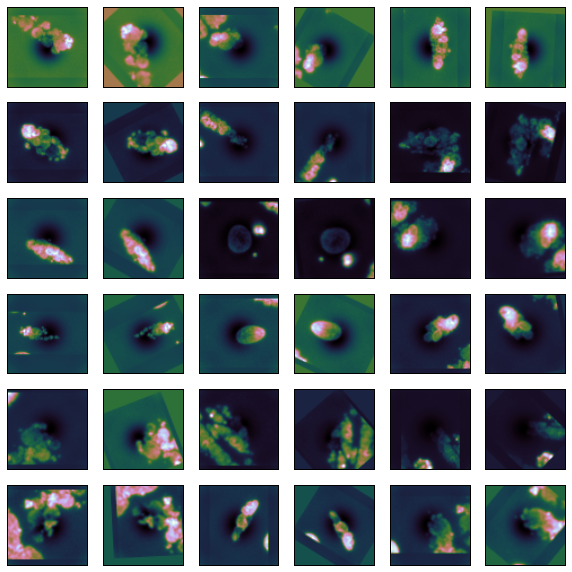

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as imgplot
import numpy as np
from skimage import transform as tf

#rots = np.deg2rad(np.asarray((90,180,0,5,-5,10,-10)))
rots = np.deg2rad(range(0,359))

dists = (-5,5)

def manipulateTrainingData(Xb):
    retX = np.zeros((Xb.shape[0], Xb.shape[1], Xb.shape[2], Xb.shape[3]), dtype='float32')
    for i in range(len(Xb)):
        rot = rots[np.random.randint(0, len(rots))]

        tf_rotate = tf.SimilarityTransform(rotation=rot)
        shift_y, shift_x = np.array((X.shape[2], X.shape[3])) / 2.
        tf_shift = tf.SimilarityTransform(translation=[-shift_x, -shift_y])
        tf_shift_inv = tf.SimilarityTransform(translation=[shift_x, shift_y])
        tform_rot = (tf_shift + (tf_rotate + tf_shift_inv))

        ## TODO add the transformations
        scale = np.random.uniform(0.9,1.10)
        d = tf.SimilarityTransform(scale=scale, translation=(np.random.randint(5),np.random.randint(5)))
        tform_other = (tform_rot + d)

        for c in range(np.shape(X)[1]):
            maxAbs = 256.0;np.max(np.abs(Xb[i,c,:,:]))
            # Needs at lease 0.11.3
            retX[i,c,:,:] = tf.warp(Xb[i,c,:,:], tform_other, preserve_range = True) # "Float Images" are only allowed to have values between -1 and 1
    return retX

Xb = np.copy(X[0:100,:,:,:])
Xb = manipulateTrainingData(Xb)

fig = plt.figure(figsize=(10,10))
for i in range(18):
    a=fig.add_subplot(6,6,2*i+1,xticks=[], yticks=[])
    plt.imshow(X[i,0,:,:], cmap=plt.get_cmap('cubehelix'))
    a=fig.add_subplot(6,6,2*i+2,xticks=[], yticks=[])
    plt.imshow(Xb[i,0,:,:], cmap=plt.get_cmap('cubehelix'))
    print('before {0} after {1}'.format(np.mean(X[i,1,:,:]), np.mean(Xb[i,1,:,:])))

In [ ]:
from nolearn.lasagne import BatchIterator

class SimpleBatchIterator(BatchIterator):

    def transform(self, Xb, yb):
        Xb, yb = super(SimpleBatchIterator, self).transform(Xb, yb)
        #return Xb[:,:,:,::-1], yb #<--- Here we do the flipping of the images
        return manipulateTrainingData(Xb), yb
    
# Setting the new batch iterator
net1Aug = net_bigger
net1Aug.max_epochs = 400
net1Aug.batch_iterator_train = SimpleBatchIterator(256)
netAug = net1Aug.fit(XX, YY)

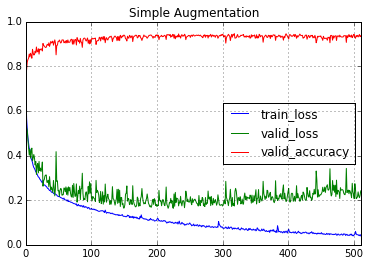

In [55]:
%matplotlib inline
import pandas as pd
dfAug = pd.DataFrame(net1Aug.train_history_)
dfAug[['train_loss','valid_loss','valid_accuracy']].plot(title='Simple Augmentation', ylim=(0,1))

In [56]:
dfAug

,dur,epoch,train_loss,train_loss_best,valid_accuracy,valid_loss,valid_loss_best
0,123.541614,1,0.717072,True,0.759562,0.594760,True
1,124.306742,2,0.565852,True,0.784461,0.525092,True
2,126.360403,3,0.517024,True,0.819631,0.511126,True
3,127.704351,4,0.480363,True,0.829524,0.468698,True
4,128.859036,5,0.457087,True,0.835812,0.434904,True
5,128.596941,6,0.431942,True,0.854702,0.402001,True
6,128.434196,7,0.428410,True,0.841759,0.428179,False
7,128.721511,8,0.399574,True,0.858164,0.388704,True
8,128.104501,9,0.384914,True,0.849885,0.421506,False
9,128.191317,10,0.378129,True,0.835902,0.433137,False


In [57]:
pred = netAug.predict(X_test)

In [58]:
sum(pred == Y_test)/float(len(Y_test))#0.8986779981114259, 0.9244570349386213, 0.93512747875354107, 0.94135977337110477 (146 Epochs)

0.93437204910292726

In [59]:
import cPickle as pickle
with open('net_PAPER_aug_epoch512_72x72large_net.pickle', 'wb') as f:
    pickle.dump(netAug, f, -1)

In [60]:
from sklearn.metrics import confusion_matrix
import pandas as pd
names = ('DMSO True', 'PACLITAXEL True', 'METOCLOPRAMIDE True', 'DIGOXIN True')
m = confusion_matrix(pred, Y_test)
df = pd.DataFrame(m)
df.columns = names
names = ('DMSO Pred', 'PACLITAXEL Pred', 'METOCLOPRAMIDE Pred', 'DIGOXIN Pred')
df.index = names
df

,DMSO True,PACLITAXEL True,METOCLOPRAMIDE True,DIGOXIN True
DMSO Pred,7775,13,208,0
PACLITAXEL Pred,28,382,23,1
METOCLOPRAMIDE Pred,414,8,1657,0
DIGOXIN Pred,0,0,0,81


### Normalizing the confusion matrix
See http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

In [61]:
#cm_normalized = m.astype('float') / ((m.sum(axis=1)[:, np.newaxis]))
cm_normalized = m.astype('float') / ((m.sum(axis=0)[np.newaxis,:]))
print('Normalized confusion matrix')
pd.DataFrame(cm_normalized)

Normalized confusion matrix


,0,1,2,3
0,0.946209,0.032258,0.110169,0.000000
1,0.003408,0.947891,0.012182,0.012195
2,0.050383,0.019851,0.877648,0.000000
3,0.000000,0.000000,0.000000,0.987805


In [62]:
np.mean(cm_normalized[np.diag_indices(4)])

0.93988827018282151

In [63]:
1 - np.mean(cm_normalized[np.diag_indices(4)])

0.060111729817178494